**1. Importing all libraries**

In [229]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sqlite3 
import scipy.stats as stats

**2. Connecting dataset**

In [230]:
def create_connection(db_file):
    global conn
    if 'conn' in globals() and conn:
        conn.close()
    conn = sqlite3.connect(db_file)
    return conn

conn = create_connection('mental_health.sqlite')

**3. Checking database**

In [231]:
query = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""
tables = conn.execute(query).fetchall()
tables = [row[0] for row in tables] 

print("Tables in the database:")
for table in tables:
    print(f" - {table}")


Tables in the database:
 - Answer
 - Question
 - Survey


By checking table names from base table schema information I can tell there are 3 tables

In [232]:
table_query = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""
tables = conn.execute(table_query).fetchall()

for table in tables:
    table_name = table[0]  

    row_count_query = f"""
    SELECT COUNT(*) 
    FROM {table_name};
    """
    row_count = conn.execute(row_count_query).fetchone()[0]

    column_query = f"""
    PRAGMA table_info({table_name});
    """
    columns = conn.execute(column_query).fetchall()
    column_names = [col[1] for col in columns]

    print(f"\nTable: {table_name}")
    print(f" - Rows: {row_count}")
    print(f" - Columns: {', '.join(column_names)}")



Table: Answer
 - Rows: 236898
 - Columns: AnswerText, SurveyID, UserID, QuestionID

Table: Question
 - Rows: 105
 - Columns: questiontext, questionid

Table: Survey
 - Rows: 5
 - Columns: SurveyID, Description


Checking each tables row count and columns with their name tags. From this I can tell that Answers is the main table which connects both Survey and Question tables.
There are 5 surveys, 105 questions and 236898 entries consisting answers. 

**4. Checking NULL values**

In [233]:
query = """
SELECT m.name AS table_name, p.name AS column_name 
FROM sqlite_master m
JOIN pragma_table_info(m.name) p
WHERE m.type='table';
"""
table_columns = conn.execute(query).fetchall() 

results = []
for table, column in table_columns:
    null_count = conn.execute(f"SELECT COUNT(*) FROM {table} WHERE {column} IS NULL;").fetchone()[0]
    if null_count > 0:
        results.append((table, column, null_count))

if results:
    print("\nNULL Values Found:")
    for table, column, count in results:
        print(f"Table: {table} | Column: {column} | NULLs: {count}")
else:
    print("No NULL values found in the database.")

No NULL values found in the database.


**6. Question order** 

By observing the database I noticed that question_id's dont go in order. To not face problems in upcoming work, I check it and change the order. 

In [235]:
query_question_ids = """
SELECT QuestionID FROM Question ORDER BY QuestionID;
"""
question_ids = [row[0] for row in conn.execute(query_question_ids).fetchall()]
new_ids = list(range(1, len(question_ids) + 1))
id_mapping_questions = dict(zip(question_ids, new_ids))

for old_id, new_id in id_mapping_questions.items():
    update_question_query = f"""
    UPDATE Question 
    SET QuestionID = {new_id} 
    WHERE QuestionID = {old_id};
    """
    conn.execute(update_question_query)

conn.commit()


query_answer_ids = """
SELECT DISTINCT QuestionID FROM Answer ORDER BY QuestionID;
"""
answer_ids = [row[0] for row in conn.execute(query_answer_ids).fetchall()]
new_ids_answers = list(range(1, len(answer_ids) + 1))
id_mapping_answers = dict(zip(answer_ids, new_ids_answers))

for old_id, new_id in id_mapping_answers.items():
    update_answer_query = f"""
    UPDATE Answer 
    SET QuestionID = {new_id} 
    WHERE QuestionID = {old_id};
    """
    conn.execute(update_answer_query)

conn.commit()


By observing data, I see that evrything goes in order, so when connecting question IDs everything should be correct.  

In [236]:
query = """
SELECT QuestionID
FROM Question 
ORDER BY QuestionID;
"""
question_ids = [row[0] for row in conn.execute(query).fetchall()]

missing_ids = [q for q in range(question_ids[0], question_ids[-1] + 1) if q not in question_ids]


if missing_ids:
    print("\nMissing QuestionIDs detected:")
    print(missing_ids)
else:
    print("All QuestionIDs are in proper sequence.")

All QuestionIDs are in proper sequence.


**5. Checking for duplicates**

In [237]:
query = """
SELECT QuestionID, UserID, COUNT(*) as duplicate_count
FROM Answer
GROUP BY QuestionID, UserID
HAVING COUNT(*) > 1;
"""

duplicates = conn.execute(query).fetchall()


if duplicates:
    print("\nDuplicate QuestionID per UserID found:")
    for row in duplicates:
        print(f"QuestionID: {row[0]} | UserID: {row[1]} | Duplicates: {row[2]}")
else:
    print("No duplicate QuestionID per UserID found.")


Duplicate QuestionID per UserID found:
QuestionID: 102 | UserID: 1262 | Duplicates: 2
QuestionID: 102 | UserID: 1264 | Duplicates: 2
QuestionID: 102 | UserID: 1265 | Duplicates: 2
QuestionID: 102 | UserID: 1266 | Duplicates: 3
QuestionID: 102 | UserID: 1268 | Duplicates: 2
QuestionID: 102 | UserID: 1270 | Duplicates: 2
QuestionID: 102 | UserID: 1275 | Duplicates: 2
QuestionID: 102 | UserID: 1277 | Duplicates: 4
QuestionID: 102 | UserID: 1279 | Duplicates: 2
QuestionID: 102 | UserID: 1280 | Duplicates: 2
QuestionID: 102 | UserID: 1290 | Duplicates: 2
QuestionID: 102 | UserID: 1292 | Duplicates: 4
QuestionID: 102 | UserID: 1295 | Duplicates: 2
QuestionID: 102 | UserID: 1301 | Duplicates: 2
QuestionID: 102 | UserID: 1304 | Duplicates: 2
QuestionID: 102 | UserID: 1306 | Duplicates: 3
QuestionID: 102 | UserID: 1307 | Duplicates: 4
QuestionID: 102 | UserID: 1310 | Duplicates: 2
QuestionID: 102 | UserID: 1314 | Duplicates: 2
QuestionID: 102 | UserID: 1327 | Duplicates: 2
QuestionID: 102 | Us

There are many duplicates anwers from many user to specific questions. To gain a better perspective, I will review the questions and answers to determine whether these duplicates are truly redundant or if they represent different answers to the same question.

In [238]:
query = """
SELECT * FROM Question
WHERE QuestionID IN (102, 103, 104);
"""
questions = conn.execute(query).fetchall()

print("\nQuestions with IDs 102, 103, and 104:")
for row in questions:
    print(row)


Questions with IDs 102, 103, and 104:
('if yes, what condition(s) have you been diagnosed with?', 102)
('if maybe, what condition(s) do you believe you have?', 103)
('which of the following best describes your work position?', 104)


In [239]:
cursor = conn.cursor()

query = """
SELECT * FROM Answer
WHERE (QuestionID = 102 AND UserID = 1292)
   OR (QuestionID = 103 AND UserID = 2065)
   OR (QuestionID = 104 AND UserID = 1499);
"""

cursor.execute(query)
results = cursor.fetchall()

print("\nRecords for specified QuestionID & UserID pairs:")
if results:
    for row in results:
        print(row)
else:
    print("No records found.")


Records for specified QuestionID & UserID pairs:
('anxiety disorder (generalized, social, phobia, etc)', 2016, 1292, 102)
('mood disorder (depression, bipolar disorder, etc)', 2016, 1292, 102)
('substance use disorder', 2016, 1292, 102)
('addictive disorder', 2016, 1292, 102)
('anxiety disorder (generalized, social, phobia, etc)', 2016, 2065, 103)
('mood disorder (depression, bipolar disorder, etc)', 2016, 2065, 103)
('post-traumatic stress disorder', 2016, 2065, 103)
('stress response syndromes', 2016, 2065, 103)
('front-end developer', 2016, 1499, 104)
('back-end developer', 2016, 1499, 104)
('sales', 2016, 1499, 104)
('devops/sysadmin', 2016, 1499, 104)


From this, I can tell that many users have provided more than one answer, indicating that these duplicates are not true duplicates but rather additional responses from users for a specific question. It would be incorrect to remove them.

**7. Standardizing the database**

In [240]:
query_tables = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""

tables = [row[0] for row in conn.execute(query_tables).fetchall()]

for table in tables:
    column_query = f"PRAGMA table_info({table})"
    columns = conn.execute(column_query).fetchall()

    for col in columns:
        col_name = col[1] 
        col_type = col[2]  

        if "CHAR" in col_type.upper() or "TEXT" in col_type.upper():
            update_query = f"""
            UPDATE {table}
            SET {col_name} = TRIM(LOWER({col_name}))
            WHERE {col_name} IS NOT NULL;
            """
            conn.execute(update_query)
        
        if "DATE" in col_type.upper() or "date" in col_name.lower():
            update_query = f"""
            UPDATE {table}
            SET {col_name} = strftime('%Y-%m-%d', {col_name})
            WHERE {col_name} IS NOT NULL AND {col_name} != '';
            """
            conn.execute(update_query)

        if "INT" in col_type.upper() or "REAL" in col_type.upper():
            update_query = f"""
            UPDATE {table}
            SET {col_name} = CAST({col_name} AS INTEGER)
            WHERE {col_name} GLOB '[0-9]*';
            """
            conn.execute(update_query)
            
conn.commit()


 1.Trim whitespace and convert text to lowercase

 2.Fix date formatting to YYYY-MM-DD
 
 3.Ensure numerical columns have correct values


## **EDA**

Now I will examine the data to gain a comprehensive understanding of the respondents.

**1. Checking how many people reponed to each survey**

In [241]:
query = """
SELECT SurveyID, COUNT(DISTINCT UserID) AS respondent_count
FROM Answer
GROUP BY SurveyID
ORDER BY respondent_count DESC;
"""

survey_responses = conn.execute(query).fetchall()

print("\nSurvey Respondent Count:")
print("SurveyID | Respondent Count")
for survey_id, respondent_count in survey_responses:
    print(f"{survey_id:<8} | {respondent_count}")


Survey Respondent Count:
SurveyID | Respondent Count
2016     | 1433
2014     | 1260
2017     | 756
2018     | 417
2019     | 352


Here, I can see that most of the answers come from 2016 and 2014. Additionally, there is no survey from 2015.

**2. Checking how many questions are in each survey**

In [242]:
cursor = conn.cursor()

query = """
SELECT SurveyID, COUNT(DISTINCT QuestionID) AS QuestionCount
FROM Answer
GROUP BY SurveyID
ORDER BY SurveyID;
"""

cursor.execute(query)
results = cursor.fetchall()

print("SurveyID | Question Count")
for row in results:
    print(f"{row[0]:<8} | {row[1]}")

SurveyID | QuestionCount
2014     | 26
2016     | 60
2017     | 76
2018     | 76
2019     | 76


Not all surveys have the same number of questions, which means that some questions will naturally have fewer answers.

**3. Correlation between the number of questions and participant enrollment**

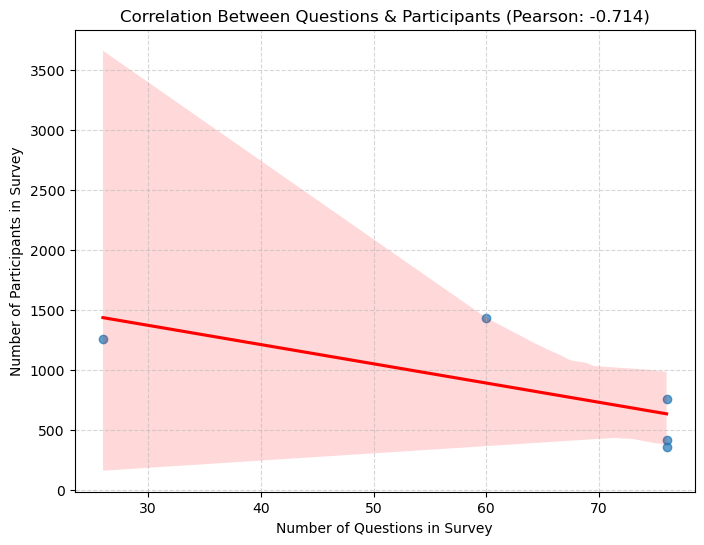

Pearson Correlation between Question Count & Participant Count: -0.71409204002644


In [258]:
cursor = conn.cursor()

query_questions = """
SELECT SurveyID, COUNT(DISTINCT QuestionID) AS QuestionCount
FROM Answer
GROUP BY SurveyID
ORDER BY SurveyID;
"""

cursor.execute(query_questions)
questions_data = cursor.fetchall()

query_participants = """
SELECT SurveyID, COUNT(DISTINCT UserID) AS ParticipantCount
FROM Answer
GROUP BY SurveyID
ORDER BY SurveyID;
"""

cursor.execute(query_participants)
participants_data = cursor.fetchall()

questions_dict = {year: count for year, count in questions_data}
participants_dict = {year: count for year, count in participants_data}
common_years = sorted(set(questions_dict.keys()) & set(participants_dict.keys()))
question_counts = [questions_dict[year] for year in common_years]
participant_counts = [participants_dict[year] for year in common_years]


pearson_corr, _ = stats.pearsonr(question_counts, participant_counts)

plt.figure(figsize=(8, 6))
sns.regplot(x=question_counts, y=participant_counts, scatter_kws={"alpha": 0.7}, line_kws={"color": "red"})
plt.xlabel("Number of Questions in Survey")
plt.ylabel("Number of Participants in Survey")
plt.title(f"Correlation Between Questions & Participants (Pearson: {pearson_corr:.3f})")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

print("Pearson Correlation between Question Count & Participant Count:", pearson_corr)


There is a strong negative correlation between the number of questions and the number of participants in the survey, which could indicate that people are reluctant to answer too many questions. I would need to contact the individuals or organizations that conducted this survey to fully understand whether this was truly the case or if there was another reason for the drop in enrollment.

**4. Age statistics for all surveys**

In [259]:
query = """
WITH valid_ages AS (
    SELECT CAST(AnswerText AS INTEGER) AS age
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
)
SELECT 
    (SELECT MIN(age) FROM valid_ages) AS youngest,
    (SELECT MAX(age) FROM valid_ages) AS oldest,
    (SELECT AVG(age) FROM valid_ages) AS mean_age,
    (SELECT age FROM valid_ages ORDER BY age LIMIT 1 OFFSET (SELECT COUNT(*)/2 FROM valid_ages)) AS median_age,
    (SELECT MAX(age) - MIN(age) FROM valid_ages) AS age_range,
    (SELECT age FROM valid_ages GROUP BY age ORDER BY COUNT(*) DESC LIMIT 1) AS mode_age
FROM valid_ages;
"""

age_stats = conn.execute(query).fetchone()
youngest, oldest, mean_age, median_age, age_range, mode_age = age_stats

print("\nAge Statistics for All Surveys:")
print("-------------------------------------------------------------------")
print(f"Youngest Respondent: {youngest}")
print(f"Oldest Respondent: {oldest}")
print(f"Mean Age: {mean_age:.2f}")
print(f"Median Age: {median_age}")
print(f"Age Range: {age_range}")
print(f"Mode Age: {mode_age}")


Age Statistics for All Surveys:
-------------------------------------------------------------------
Youngest Respondent: 0
Oldest Respondent: 329
Mean Age: 33.97
Median Age: 33
Age Range: 329
Mode Age: 30


As there are outlyers like 0 and 329 , I apply a range for this data extraction starting from 16 (some interns or young freelancers) and 80 (some seniors that work in IT sector)

**5. Age statistics for all surveys in range of ages 16-80**

In [260]:
query = """
WITH valid_ages AS (
    SELECT CAST(AnswerText AS INTEGER) AS age
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
)
SELECT 
    (SELECT MIN(age) FROM valid_ages) AS youngest,
    (SELECT MAX(age) FROM valid_ages) AS oldest,
    (SELECT AVG(age) FROM valid_ages) AS mean_age,
    (SELECT age FROM valid_ages ORDER BY age LIMIT 1 OFFSET (SELECT COUNT(*)/2 FROM valid_ages)) AS median_age,
    (SELECT MAX(age) - MIN(age) FROM valid_ages) AS age_range,
    (SELECT age FROM valid_ages GROUP BY age ORDER BY COUNT(*) DESC LIMIT 1) AS mode_age,
    (SELECT COUNT(*) FROM valid_ages) AS total_respondents
FROM valid_ages;
"""

age_stats = conn.execute(query).fetchone()
youngest, oldest, mean_age, median_age, age_range, mode_age, total_respondents = age_stats

print("\nAge Statistics for All Surveys (Ages 16-80):")
print("-------------------------------------------------------------------")
print(f"Youngest Respondent: {youngest}")
print(f"Oldest Respondent: {oldest}")
print(f"Mean Age: {mean_age:.2f}")
print(f"Median Age: {median_age}")
print(f"Age Range: {age_range}")
print(f"Mode Age: {mode_age}")
print(f"Total Respondents in Range 16-80: {total_respondents}")


Age Statistics for All Surveys (Ages 16-80):
-------------------------------------------------------------------
Youngest Respondent: 17
Oldest Respondent: 74
Mean Age: 33.86
Median Age: 33
Age Range: 57
Mode Age: 30
Total Respondents in Range 16-80: 4203


**6. Age distribution of respondents in range of ages 16-80**

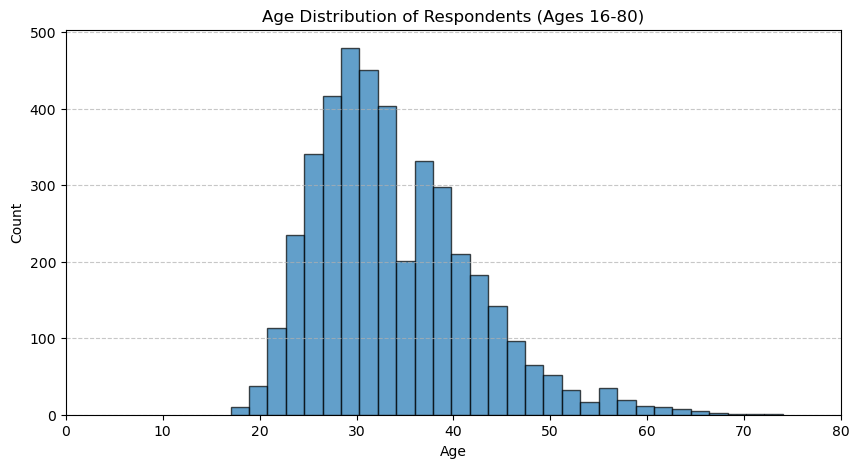

In [246]:
query = """
SELECT CAST(AnswerText AS INTEGER) AS age
FROM Answer
WHERE QuestionID = 1
AND AnswerText GLOB '[0-9]*';
"""

ages = [row[0] for row in conn.execute(query).fetchall()]
filtered_ages = [age for age in ages if 16 <= age <= 80]

plt.figure(figsize=(10, 5))
plt.hist(filtered_ages, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of Respondents (Ages 16-80)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, 81, 10))
plt.show()

From this I can see that age distributions is more left skewed, which means most of the respondents who answered in this tech query are relatively young (from early 20 til late 40)

**7.Country distribution of respondents in range of ages 16-80**

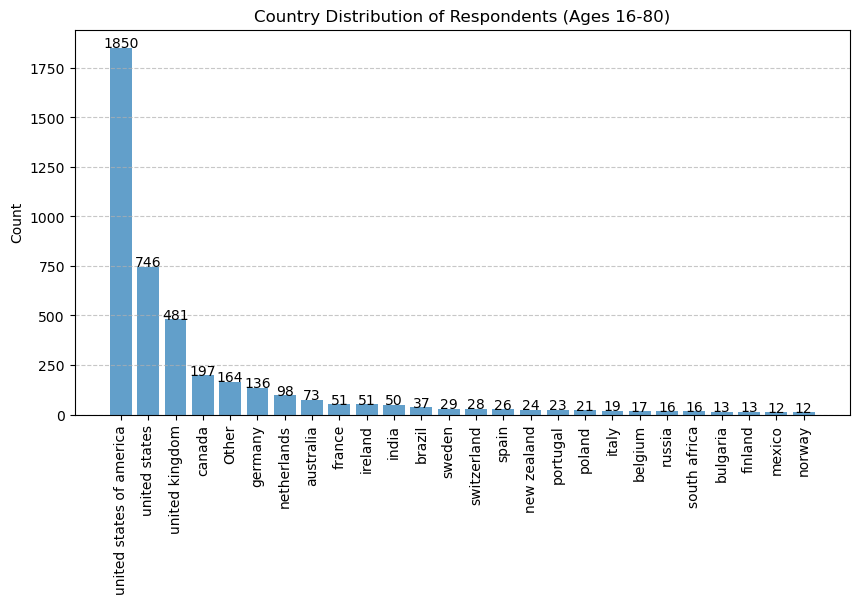

In [247]:
query = """
WITH valid_ages AS (
    SELECT UserID
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
),
country_counts AS (
    SELECT AnswerText AS country, COUNT(*) AS count
    FROM Answer
    WHERE QuestionID = 3
    AND UserID IN (SELECT UserID FROM valid_ages)
    GROUP BY AnswerText
),
filtered_countries AS (
    SELECT country, count FROM country_counts WHERE count > 10
    UNION ALL
    SELECT 'Other' AS country, SUM(count) FROM country_counts WHERE count <= 10
)
SELECT country, count FROM filtered_countries ORDER BY count DESC;
"""

country_stats = conn.execute(query).fetchall()
country_labels, country_counts = zip(*country_stats)

custom_color = '#629fca'
plt.figure(figsize=(10, 5))
plt.bar(country_labels, country_counts, color=[custom_color] * len(country_labels)) 

for i, v in enumerate(country_counts):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10)

plt.title("Country Distribution of Respondents (Ages 16-80)")
plt.ylabel("Count")
plt.xticks(rotation=90) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

I see that most of the respondats are from United Stets as first 2 columns both containe answer to this country. UK and Canada comes as next. 
Take in that this distribution is scewed left, I can tell that this survery is bised toward USA tech sector.  

**8.Average age per country in range of ages 16-80**

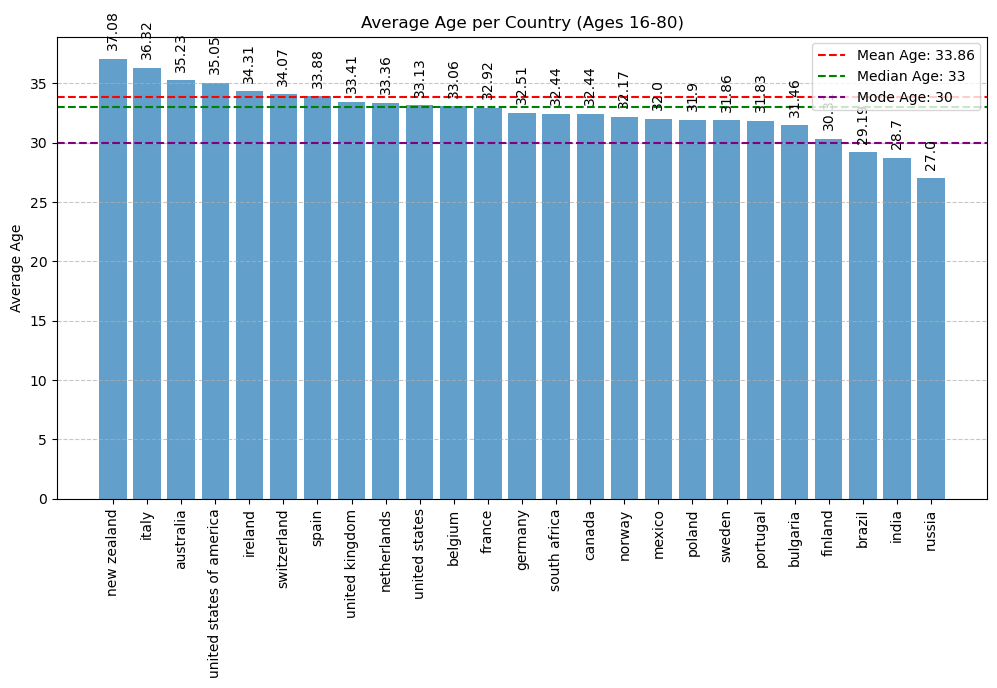

In [248]:
query = """
WITH valid_ages AS (
    SELECT UserID, CAST(AnswerText AS INTEGER) AS age
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
),
country_respondents AS (
    SELECT AnswerText AS country, va.age
    FROM Answer a
    JOIN valid_ages va ON a.UserID = va.UserID
    WHERE a.QuestionID = 3
),
country_counts AS (
    SELECT country, COUNT(*) AS count, AVG(age) AS avg_age
    FROM country_respondents
    GROUP BY country
    HAVING COUNT(*) > 10
)
SELECT country, avg_age FROM country_counts ORDER BY avg_age DESC;
"""

country_age_stats = conn.execute(query).fetchall()
country_labels, avg_ages = zip(*country_age_stats)

query_stats = """
WITH valid_ages AS (
    SELECT CAST(AnswerText AS INTEGER) AS age
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
)
SELECT 
    AVG(age) AS mean_age,
    (SELECT age FROM valid_ages ORDER BY age LIMIT 1 OFFSET (SELECT COUNT(*)/2 FROM valid_ages)) AS median_age,
    (SELECT age FROM valid_ages GROUP BY age ORDER BY COUNT(*) DESC LIMIT 1) AS mode_age
FROM valid_ages;
"""

mean_age, median_age, mode_age = conn.execute(query_stats).fetchone()


plt.figure(figsize=(12, 6))
plt.bar(country_labels, avg_ages, color="#629fca")

for i, v in enumerate(avg_ages):
    plt.text(i, v + 1, str(round(v, 2)), ha='center', fontsize=10, rotation=90)

plt.axhline(mean_age, color='red', linestyle='--', label=f'Mean Age: {round(mean_age, 2)}')
plt.axhline(median_age, color='green', linestyle='--', label=f'Median Age: {median_age}')
plt.axhline(mode_age, color='purple', linestyle='--', label=f'Mode Age: {mode_age}')
plt.title("Average Age per Country (Ages 16-80)")
plt.ylabel("Average Age")
plt.xticks(rotation=90) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most countries have an average age between 30-35 years, with only a few significantly above or below this range.

The age distribution seems slightly skewed towards younger participants, as indicated by the mode age (30 years), which is lower than the mean and median. Countries like Spain, the United Kingdom, the Netherlands, the United States, and Belgium are very close to the mean value, suggesting that they have an age distribution typical of the dataset.

 The relatively small gap between mean, median, and mode suggests a fairly symmetrical distribution of ages.

**9.Gender distribution of respondents in range of ages 16-80**

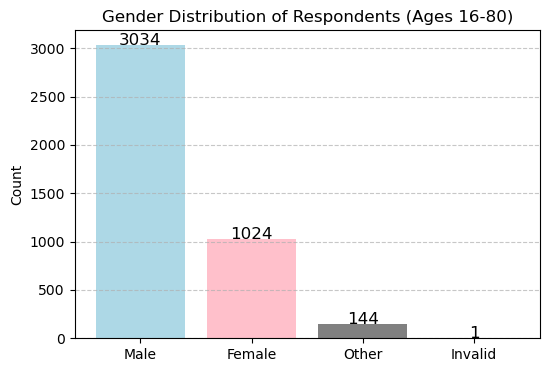

In [249]:
query = """
WITH valid_ages AS (
    SELECT UserID
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
),
gender_counts AS (
    SELECT 
        CASE 
            WHEN LOWER(AnswerText) IN ('male', 'man') THEN 'Male'
            WHEN LOWER(AnswerText) IN ('female', 'woman') THEN 'Female'
            WHEN AnswerText GLOB '[0-9]*' THEN 'Invalid'
            ELSE 'Other'
        END AS gender_category
    FROM Answer
    WHERE QuestionID = 2
    AND UserID IN (SELECT UserID FROM valid_ages)
)
SELECT gender_category, COUNT(*) as count
FROM gender_counts
GROUP BY gender_category;
"""

gender_stats = conn.execute(query).fetchall()
sorted_gender_data = sorted(gender_stats, key=lambda x: x[1], reverse=True)
gender_labels_sorted, gender_counts_sorted = zip(*sorted_gender_data)

plt.figure(figsize=(6, 4))
plt.bar(gender_labels_sorted, gender_counts_sorted, color=['lightblue', 'pink', 'gray', 'red'])

for i, v in enumerate(gender_counts_sorted):
    plt.text(i, v + 2, str(v), ha='center', fontsize=12)

plt.title("Gender Distribution of Respondents (Ages 16-80)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From this plot, I can tell that most participants in the surveys, aged 16–80, are males, with females comprising about a third of the responses. Additionally, 144 answers fall into the "Other" category, indicating that these respondents provided alternative answers (e.g., Transgender).

One answer is invalid because it is numerical.

Taking this into account, I can tell that these queries are biased toward males. However, they also showcast reall life situation in the tech industry, as around 20–35% of all employees are female (based on multiple sources found on Google).

**10. Race distribution of respondents in range of ages 16-80**

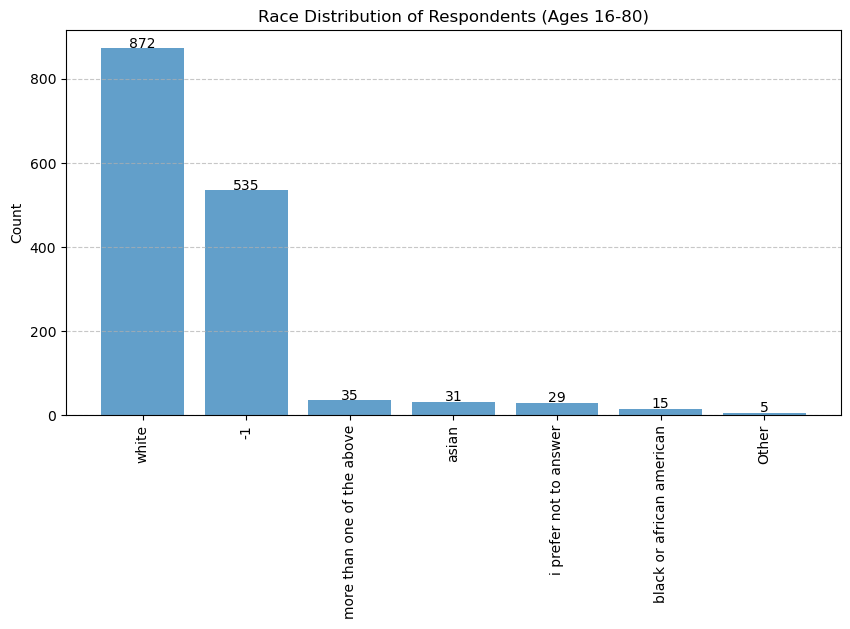

In [250]:
query_race_distribution = """
WITH valid_ages AS (
    SELECT UserID
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
),
race_counts AS (
    SELECT AnswerText AS race, COUNT(*) AS count
    FROM Answer
    WHERE QuestionID = 76
    AND UserID IN (SELECT UserID FROM valid_ages)
    GROUP BY AnswerText
),
filtered_races AS (
    SELECT race, count FROM race_counts WHERE count > 10
    UNION ALL
    SELECT 'Other' AS race, COALESCE(SUM(count), 0) FROM race_counts WHERE count <= 10
)
SELECT race, count FROM filtered_races ORDER BY count DESC;
"""

race_stats = conn.execute(query_race_distribution).fetchall()
race_labels, race_counts = zip(*[(row[0], row[1] if row[1] is not None else 0) for row in race_stats])


custom_color = "#629fca"
plt.figure(figsize=(10, 5))
plt.bar(race_labels, race_counts, color=[custom_color] * len(race_labels))  

for i, v in enumerate(race_counts):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10)

plt.title("Race Distribution of Respondents (Ages 16-80)")
plt.ylabel("Count")
plt.xticks(rotation=90)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most of the survey participants who responded are classified as "white." It is hard to determine the meaning of "-1" without additional context, but I can make an educated guess that it indicates the person did not answer this question. The remaining responses are in very small numbers. Based on the number of answers, it seems that this question was included in later surveys, which had lower enrollment compared to the first two. From this I can tell also that surverys are biased by "white" people. 

**11. Top 10 most mentioned mental illnesses from all responses**

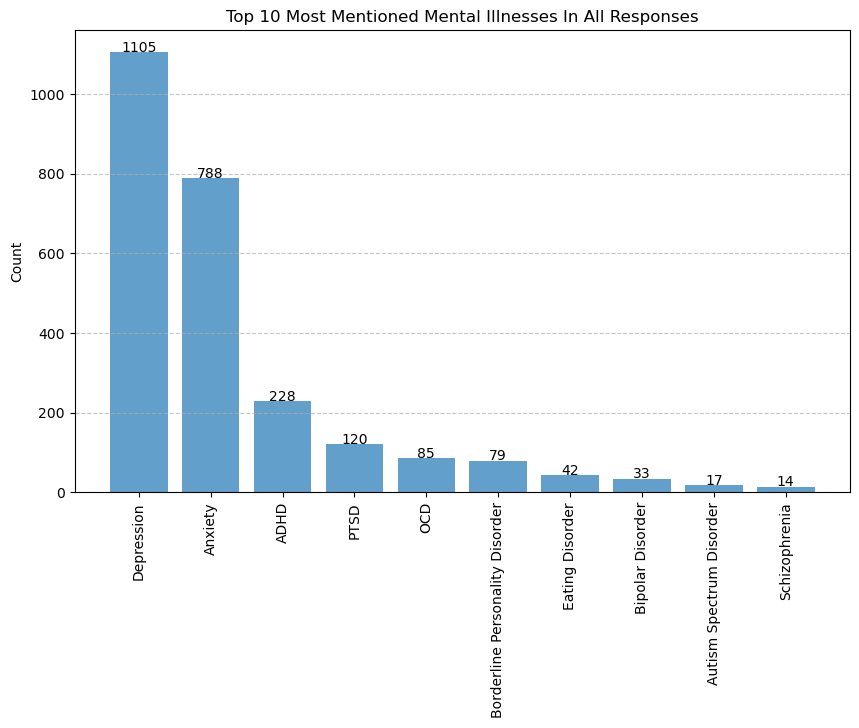

In [251]:
query_top_mental_illnesses = """
WITH extracted_illnesses AS (
    SELECT LOWER(AnswerText) AS answer
    FROM Answer
    WHERE AnswerText IS NOT NULL
),
illness_counts AS (
    SELECT 
        CASE 
            WHEN answer LIKE '%depression%' OR answer LIKE '%depresion%' THEN 'Depression'
            WHEN answer LIKE '%anxiety%' THEN 'Anxiety'
            WHEN answer LIKE '%bipolar%' THEN 'Bipolar Disorder'
            WHEN answer LIKE '%schizophrenia%' THEN 'Schizophrenia'
            WHEN answer LIKE '%ocd%' OR answer LIKE '%obsessive-compulsive%' THEN 'OCD'
            WHEN answer LIKE '%ptsd%' OR answer LIKE '%post-traumatic%' THEN 'PTSD'
            WHEN answer LIKE '%adhd%' OR answer LIKE '%attention deficit%' THEN 'ADHD'
            WHEN answer LIKE '%autism%' OR answer LIKE '%autistic%' THEN 'Autism Spectrum Disorder'
            WHEN answer LIKE '%borderline%' THEN 'Borderline Personality Disorder'
            WHEN answer LIKE '%eating disorder%' OR answer LIKE '%bulimia%' OR answer LIKE '%anorexia%' THEN 'Eating Disorder'
            ELSE NULL
        END AS mental_illness
    FROM extracted_illnesses
)
SELECT mental_illness, COUNT(*) AS count
FROM illness_counts
WHERE mental_illness IS NOT NULL
GROUP BY mental_illness
ORDER BY count DESC
LIMIT 10;
"""

top_mental_illnesses = conn.execute(query_top_mental_illnesses).fetchall()
mental_illness_labels, illness_counts = zip(*top_mental_illnesses)

plt.figure(figsize=(10, 6))
plt.bar(mental_illness_labels, illness_counts, color="#629fca")

for i, v in enumerate(illness_counts):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10, rotation=0)

plt.title("Top 10 Most Mentioned Mental Illnesses In All Responses")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

I can see that the most commonly mentioned mental illnesses in this survey are Depression, Anxiety, ADHD, and PTSD, followed by OCD and BPD.

**12. Top 4 mental health illneses and their prevalance rate in surveys**

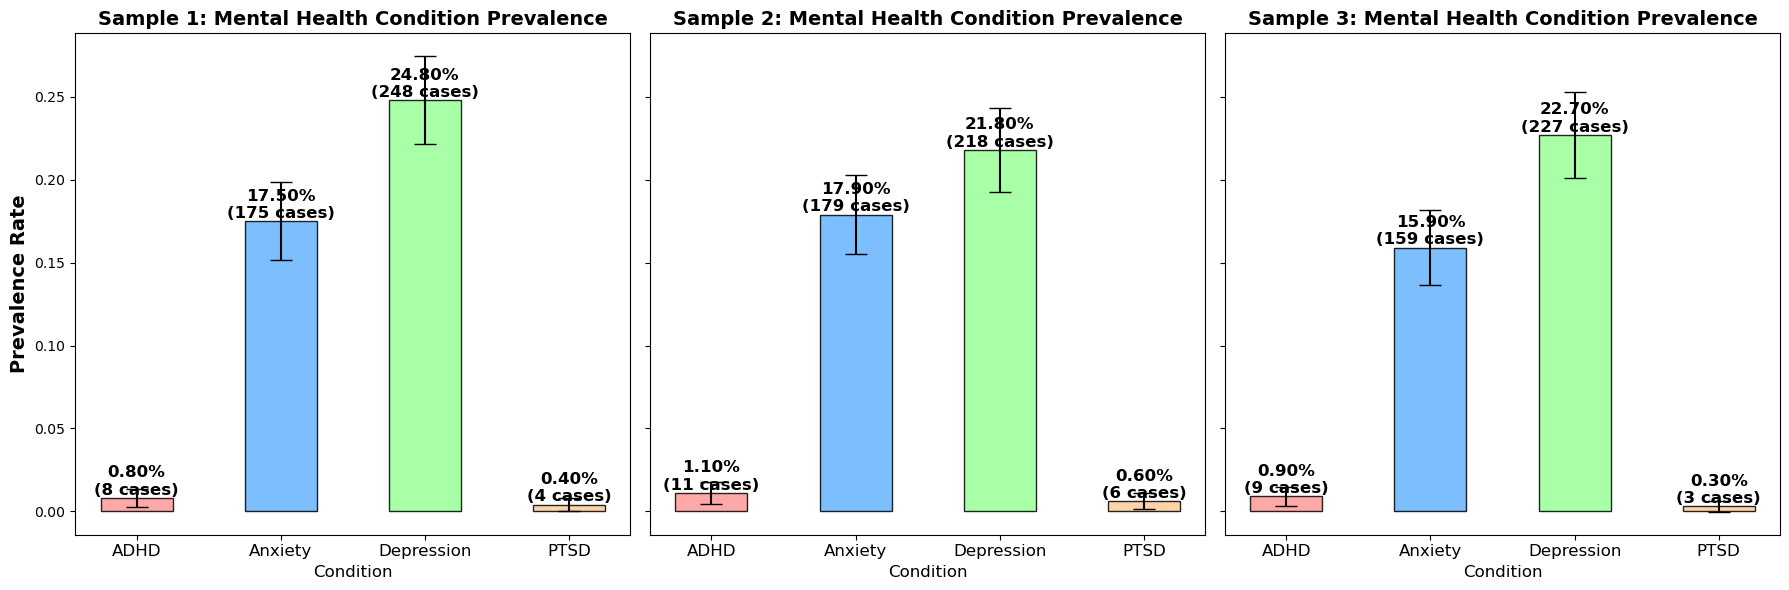

In [280]:
conditions = ["depression", "anxiety", "adhd", "ptsd"]
num_samples = 3 
all_samples = []

for i in range(num_samples):
    query = """
        SELECT DISTINCT UserID FROM Answer
        ORDER BY RANDOM()
        LIMIT 1000;
    """
    random_users_df = pd.read_sql(query, conn)
    random_users = tuple(random_users_df["UserID"].tolist())

    query = f"""
        SELECT 
            CASE 
                WHEN AnswerText LIKE '%depression%' THEN 'Depression'
                WHEN AnswerText LIKE '%anxiety%' THEN 'Anxiety'
                WHEN AnswerText LIKE '%adhd%' THEN 'ADHD'
                WHEN AnswerText LIKE '%ptsd%' THEN 'PTSD'
            END AS condition,
            COUNT(DISTINCT UserID) AS count
        FROM Answer
        WHERE UserID IN {random_users}
        AND (
            AnswerText LIKE '%depression%' OR
            AnswerText LIKE '%anxiety%' OR
            AnswerText LIKE '%adhd%' OR
            AnswerText LIKE '%ptsd%'
        )
        GROUP BY condition;
    """
    prevalence_data = pd.read_sql(query, conn)
    prevalence_data["Sample"] = f"Sample {i+1}"
    prevalence_data["prevalence"] = prevalence_data["count"] / 1000 

    z_score = 1.95
    prevalence_data["CI"] = z_score * np.sqrt((prevalence_data["prevalence"] * (1 - prevalence_data["prevalence"])) / 1000)
    
    all_samples.append(prevalence_data)


prevalence_df = pd.concat(all_samples, ignore_index=True)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, sample_name in enumerate(["Sample 1", "Sample 2", "Sample 3"]):
    sample_data = prevalence_df[prevalence_df["Sample"] == sample_name]

    bars = axes[i].bar(sample_data["condition"], sample_data["prevalence"], 
                       yerr=sample_data["CI"], capsize=8, 
                       color=["#ff9999", "#66b3ff", "#99ff99", "#ffcc99"], alpha=0.85,
                       edgecolor="black", width=0.5)
    
    axes[i].set_title(f"{sample_name}: Mental Health Condition Prevalence", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Condition", fontsize=12)
    
    axes[i].set_xticks(range(len(sample_data["condition"])))
    axes[i].set_xticklabels(sample_data["condition"], fontsize=12)
    
    for bar, rate, count in zip(bars, sample_data["prevalence"], sample_data["count"]):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                     f"{rate*100:.2f}%\n({count} cases)", ha='center', fontsize=12, fontweight="bold")


axes[0].set_ylabel("Prevalence Rate", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

The visualization shows that Depression and Anxiety are the most commonly reported mental health conditions, consistently appearing at higher prevalence rates than ADHD and PTSD across all three random samples. The confidence intervals suggest that these estimates are reliable, with minimal overlap between conditions, reinforcing the trend. While the results indicate a stable distribution of mental health conditions, there could be potential self-selection bias.

**13. Mental health problems and their awareness.**

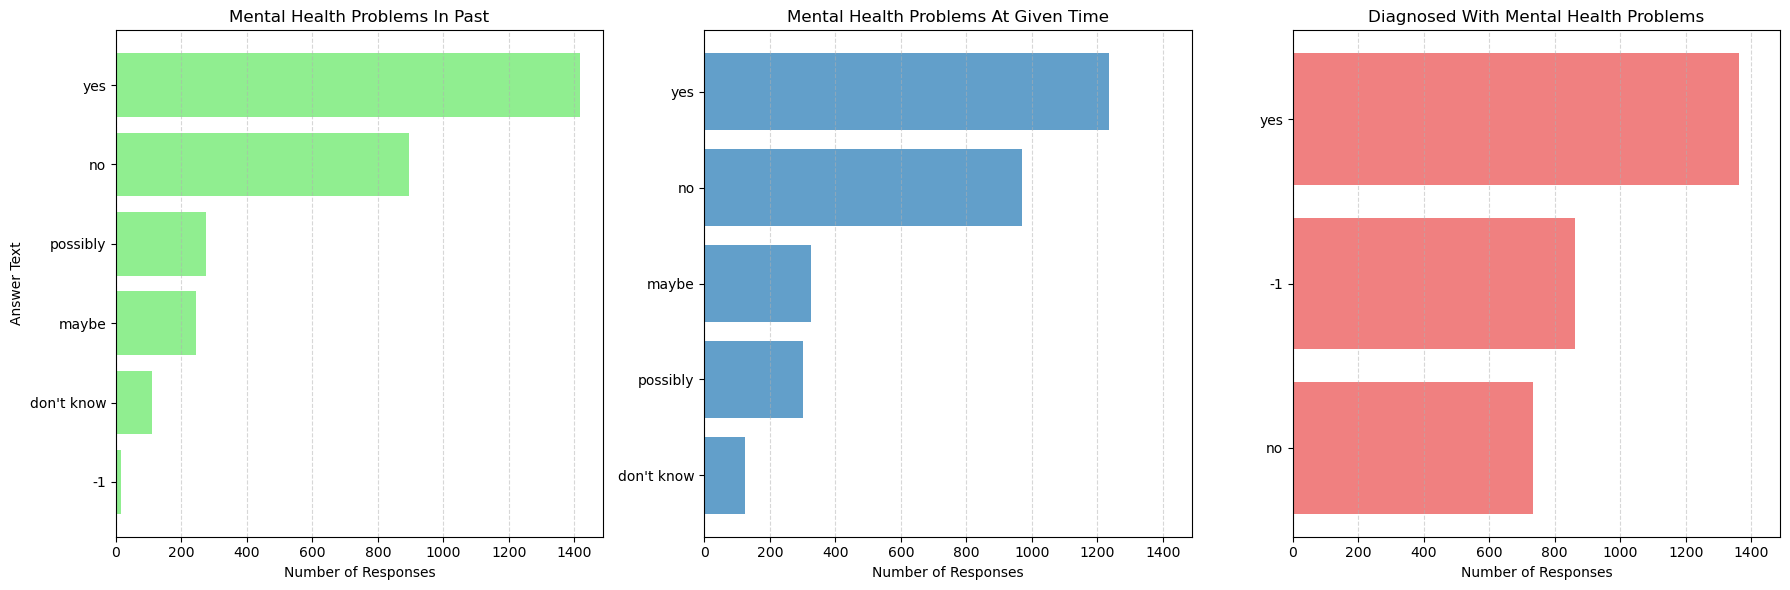

In [278]:
cursor = conn.cursor()

def get_answer_counts(question_id):
    query = f"""
    SELECT AnswerText, COUNT(*) AS ResponseCount
    FROM Answer
    WHERE QuestionID = {question_id}
    GROUP BY AnswerText
    ORDER BY ResponseCount DESC;
    """
    cursor.execute(query)
    return cursor.fetchall()

answers_32 = get_answer_counts(32)
answers_33 = get_answer_counts(33)
answers_34 = get_answer_counts(34)
answer_texts_32, response_counts_32 = zip(*answers_32) if answers_32 else ([], [])
answer_texts_33, response_counts_33 = zip(*answers_33) if answers_33 else ([], [])
answer_texts_34, response_counts_34 = zip(*answers_34) if answers_34 else ([], [])

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

axes[0].barh(answer_texts_32, response_counts_32, color="lightgreen")
axes[0].set_xlabel("Number of Responses")
axes[0].set_ylabel("Answer Text")
axes[0].set_title("Mental Health Problems In Past")
axes[0].invert_yaxis() 
axes[0].grid(axis="x", linestyle="--", alpha=0.5)

axes[1].barh(answer_texts_33, response_counts_33, color="#629fca")
axes[1].set_xlabel("Number of Responses")
axes[1].set_title("Mental Health Problems At Given Time")
axes[1].invert_yaxis()
axes[1].grid(axis="x", linestyle="--", alpha=0.5)

axes[2].barh(answer_texts_34, response_counts_34, color="lightcoral")
axes[2].set_xlabel("Number of Responses")
axes[2].set_title("Diagnosed With Mental Health Problems")
axes[2].invert_yaxis()
axes[2].grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


Slightly more participants report having experienced mental health issues in the past than currently, suggesting some recovery or changes over time. The number of officially diagnosed individuals is lower than those who self-report struggles, indicating possible underdiagnosis or barriers to seeking professional help. The gap between past and present mental health issues may reflect fluctuations in mental health or access to support.

**14. Mental health history in family**

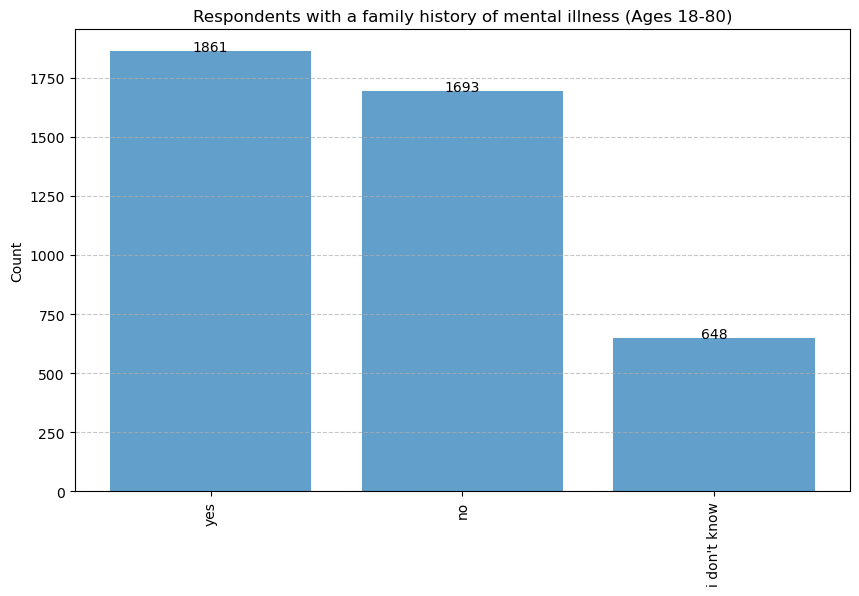

In [253]:
query = """
WITH valid_ages AS (
    SELECT UserID
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 18 AND 80
),
question_responses AS (
    SELECT AnswerText
    FROM Answer
    WHERE QuestionID = 6
    AND UserID IN (SELECT UserID FROM valid_ages)
)
SELECT AnswerText, COUNT(*) AS count
FROM question_responses
GROUP BY AnswerText
ORDER BY count DESC;
"""

responses = conn.execute(query).fetchall()
answer_texts, counts = zip(*responses)

plt.figure(figsize=(10, 6))
plt.bar(answer_texts, counts, color="#629fca")

for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=10, rotation=0) 

plt.title("Respondents with a family history of mental illness (Ages 18-80)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The bar chart suggests that a notable portion of respondents have a family history of mental illness, though the specific breakdown varies. This could indicate a genetic or environmental factor influencing mental health conditions. Further analysis could explore how this correlates with personal mental health status or workplace discussions.

**15.Mental health in work environment**

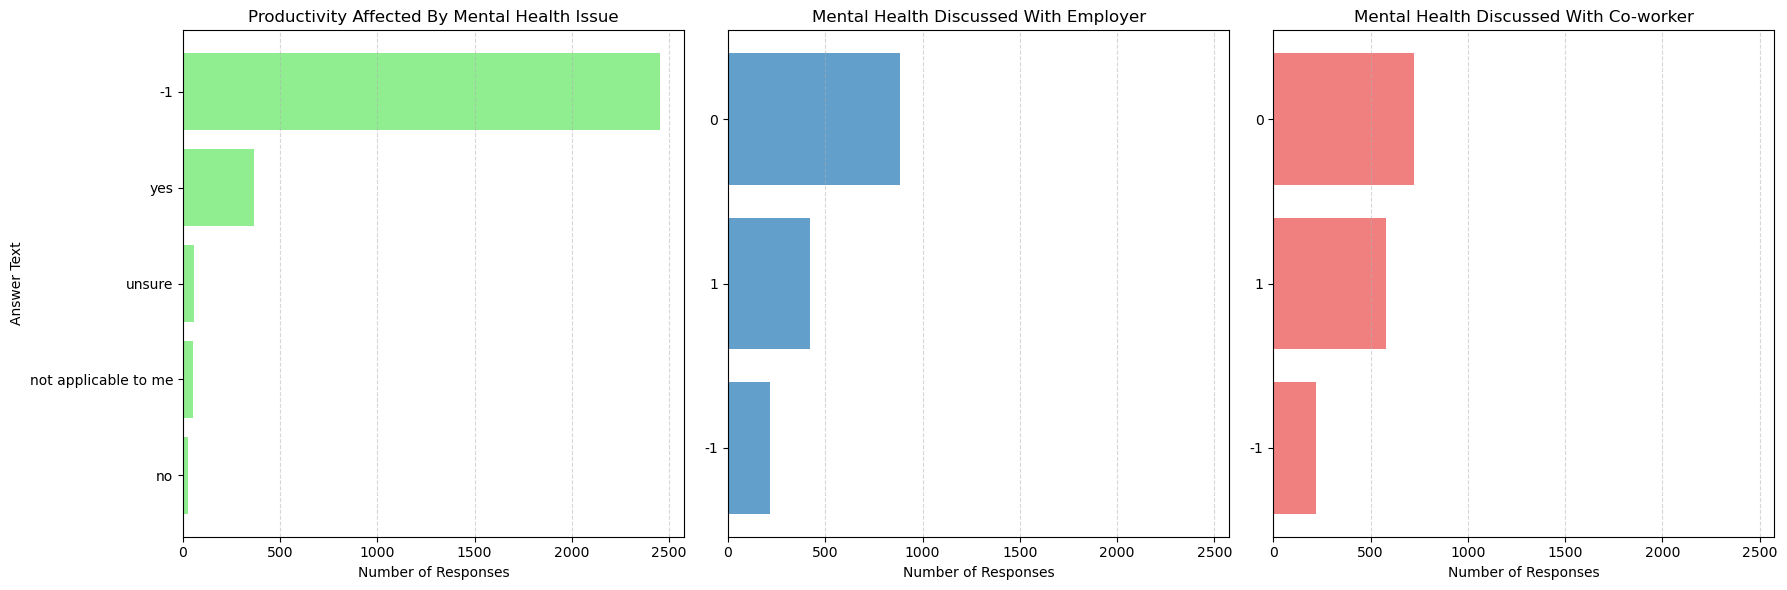

In [263]:
cursor = conn.cursor()

def get_answer_counts(question_id):
    query = f"""
    SELECT AnswerText, COUNT(*) AS ResponseCount
    FROM Answer
    WHERE QuestionID = {question_id}
    GROUP BY AnswerText
    ORDER BY ResponseCount DESC;
    """
    cursor.execute(query)
    return cursor.fetchall()

answers_41 = get_answer_counts(41)
answers_45 = get_answer_counts(45)
answers_47 = get_answer_counts(47)
answer_texts_41, response_counts_41 = zip(*answers_41) if answers_41 else ([], [])
answer_texts_45, response_counts_45 = zip(*answers_45) if answers_45 else ([], [])
answer_texts_47, response_counts_47 = zip(*answers_47) if answers_47 else ([], [])


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

axes[0].barh(answer_texts_41, response_counts_41, color="lightgreen")
axes[0].set_xlabel("Number of Responses")
axes[0].set_ylabel("Answer Text")
axes[0].set_title("Productivity Affected By Mental Health Issue")
axes[0].invert_yaxis()  
axes[0].grid(axis="x", linestyle="--", alpha=0.5)

axes[1].barh(answer_texts_45, response_counts_45, color="#629fca")
axes[1].set_xlabel("Number of Responses")
axes[1].set_title("Mental Health Discussed With Employer")
axes[1].invert_yaxis()
axes[1].grid(axis="x", linestyle="--", alpha=0.5)

axes[2].barh(answer_texts_47, response_counts_47, color="lightcoral")
axes[2].set_xlabel("Number of Responses")
axes[2].set_title("Mental Health Discussed With Co-worker")
axes[2].invert_yaxis()
axes[2].grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


There is not enough information to make any educated guesses about mental health and the work environment, specifically whether mental health is discussed in workplace settings. Additionally, it appears that these questions were added to the survey later, as there are fewer responses. Regarding the impact of mental health on productivity, a significant number of participants seem to have skipped this question.